In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# neural network stuff
class layer:
    'Neural network dense layer'
    
    # initialization (weights and biases)
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.01*np.random.randn(n_inputs, n_neurons) 
        self.biases = np.zeros((1,n_neurons))

    # output
    def forward(self, inputs):
        self.output = inputs.dot(self.weights) + self.biases
        
        # remember input values
        self.inputs = inputs
      
    def backward(self, dvalues):
        
        # gradient
        self.dinputs = dvalues.dot(self.weights.T)
        
        # Gradients on parameters
        self.dweights = self.inputs.T.dot(dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)


class dropout:
    'dropout layer'
    
    # initialization - set the dropout rate
    def __init__(self, rate):
        self.rate = rate
        
    # forward pass
    def forward(self, inputs):
        # save inputs 
        self.inputs = inputs
        # mask - inputs not set to zero are scaled up by 1/(1-rate)
        self.mask = np.random.binomial(1, 1 - self.rate, size = inputs.shape) / (1 - self.rate)
        # apply mask
        self.output = inputs * self.mask
        
    # backward pass
    def backward(self, dvalues):
        self.dinputs = dvalues*self.mask
        
class activation_ReLU:
    'rectified linear unit activation function'
    
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)
        
        # remember input values
        self.inputs = inputs
        
    def backward(self, dvalues):

        # copy dvalues
        self.dinputs = dvalues.copy()
        
        # zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0
        
class activation_softmax:
    'softmax activation function'
    
    def forward(self, inputs):
        
        # unnormalized probabilities
        exp_values = np.exp(inputs-np.max(inputs,axis=1, keepdims=True))
        
        # normalized probabilities
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilities
        
        # remember input values
        self.inputs = inputs
        
    def backward(self,dvalues):

        
        # initialized gradient (derivative) array
        self.dinputs = np.zeros(dvalues.shape)
        
        # For each data point, compute gradient
        for i in range(len(dvalues)):
            output_row = self.output[i]
            dvalues_row = dvalues[i]
            
            # Flatten output array
            output_row = output_row.reshape(-1, 1)

            # Calculate derivative matrix of the output
            derivative_matrix = np.diagflat(output_row) - output_row.dot(output_row.T)
            
            # store gradient
            self.dinputs[i] = dvalues_row.dot(derivative_matrix)


class loss:
    def calculate(self, output,y):
        sample_losses = self.forward(output,y)
        loss = np.mean(sample_losses)
        return loss
    
# cross-entropy loss        
class loss_crossentropy(loss):
    
    def forward(self, y_pred, y_true):
        
        # number of data points
        n_samples = len(y_pred)
        
        # clip data to prevent division by 0
        y_pred_clipped = np.clip(y_pred, 1e-7,1 - 1e-7)
        
        # confidence values
        confidence_values = y_pred_clipped[range(n_samples),y_true]
       
        # sample losses 
        losses = -np.log(confidence_values)
        return losses
    
    
    def backward(self, dvalues, y_true):
        
        
        # Number of samples
        n_samples = len(dvalues)
    
        #one-hot matrix
        Y = np.zeros(dvalues.shape)
        Y[np.arange(len(y_true)),y_true] = 1
        
        # Calculate gradient
        self.dinputs = -Y / dvalues
        
        # Normalize gradient
        self.dinputs = self.dinputs / n_samples
        
# GD optimizer
class optimizer_GD:

    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layer):
        layer.weights = layer.weights - self.learning_rate*layer.dweights
        layer.biases = layer.biases - self.learning_rate*layer.dbiases
        
# Adam optimizer
class optimizer_Adam:
    
    # Initialize optimizer - set parameters
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7,beta_1=0.9, beta_2=0.999):
        
        # learning rate
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        
        # decay parameters
        self.decay = decay
        
        # number of epochs
        self.epoch = 0
        
        # update learning rate parameter
        self.epsilon = epsilon
        
        # momentum parameter
        self.beta_1 = beta_1
        
        # cache parameter
        self.beta_2 = beta_2
        
        
    # update learning rate
    def pre_update_parameters(self):
        
        # update learning rate
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1 / (1 + self.decay * self.epoch))
            
    # Update weights/biases
    def update_parameters(self, layer):
        
        # If layer does not contain cache/momentum arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            
            # weights
            layer.weight_momentums = np.zeros(layer.weights.shape)
            layer.weight_cache = np.zeros(layer.weights.shape)
            
            # biases
            layer.bias_momentums = np.zeros(layer.biases.shape)
            layer.bias_cache = np.zeros(layer.biases.shape)
            
        # momentums
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases
        
        # corrected momentums
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.epoch + 1))
        
        # cache
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2  
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2
        
        # corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.epoch + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.epoch + 1))
        
        # update weights and biases
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)
        
    # update epoch
    def post_update_parameters(self):
        self.epoch += 1

In [85]:
layer_output = np.random.rand(10)
layer_output 

array([0.40262705, 0.59171838, 0.95679971, 0.63612949, 0.2589342 ,
       0.05383407, 0.09471605, 0.95904163, 0.20476997, 0.13122924])

In [86]:
# dropout rate
rate = 0.5

In [87]:
mask = np.random.binomial(1, 1-rate, size=10) # 0 with probability rate, 1 with probability 1-rate
mask

array([1, 0, 1, 1, 0, 1, 1, 0, 1, 0])

In [88]:
layer_output = layer_output*mask
layer_output

array([0.40262705, 0.        , 0.95679971, 0.63612949, 0.        ,
       0.05383407, 0.09471605, 0.        , 0.20476997, 0.        ])

In [89]:
# to compensate the dropout layer
layer_output = layer_output/(1-dropout_rate)
layer_output

array([0.80525411, 0.        , 1.91359942, 1.27225899, 0.        ,
       0.10766813, 0.18943211, 0.        , 0.40953993, 0.        ])

## Example

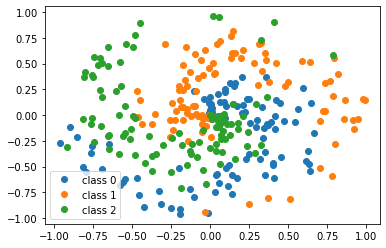

In [58]:
# spirals dataset
classes = 3
n_points = 100
noise = 0.75

X = np.zeros((n_points*classes, 2))
y = np.zeros(n_points*classes).astype('int')

for class_number in range(classes):
    ix = range(n_points*class_number, n_points*(class_number+1))
    r = np.linspace(0,1, n_points)
    t = np.linspace(class_number*4, (class_number+1)*4, n_points) + np.random.randn(n_points)*noise
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = class_number
    
# plot the dataset
for i in range(classes):
    plt.plot(X[y==i,0],X[y==i,1],'o', label='class '+str(i))
plt.legend()

## No Dropout Layers

In [59]:
# neural network 
layer1 = layer(n_inputs = 2, n_neurons = 100)
activation1 = activation_ReLU()
layer2 = layer(n_inputs = 100, n_neurons = 3)
activation2 = activation_softmax()
loss_function = loss_crossentropy()

In [60]:
# optimizer
optimizer = optimizer_Adam(learning_rate = 0.05) 

In [61]:
n_epochs = 2000
loss_adam = np.zeros(n_epochs)
accuracy_adam = np.zeros(n_epochs)
for i in range(n_epochs):
    
    # forward pass
    layer1.forward(X)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    
    # loss
    losses = loss_function.forward(activation2.output,y)
    loss_adam[i] = np.mean(losses)
    
    # accuracy
    y_pred = np.argmax(activation2.output,axis=1)
    accuracy_adam[i] = 100*np.sum(y_pred == y)/len(y)
    
    # backward pass
    loss_function.backward(activation2.output,y)
    activation2.backward(loss_function.dinputs)
    layer2.backward(activation2.dinputs)
    activation1.backward(layer2.dinputs)
    layer1.backward(activation1.dinputs)
    
    # update weights and biases
    optimizer.pre_update_parameters()
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.post_update_parameters()
    
    # print loss and accuracy every 100 epochs
    if i % 100 == 0:
        print('epoch: '+str(i))
        print('loss: '+str(np.round(loss_adam[i],3)))
        print('accuracy: '+str(np.round(accuracy_adam[i],3)))
        print('------------------------')

epoch: 0
loss: 1.099
accuracy: 32.0
------------------------
epoch: 100
loss: 0.362
accuracy: 86.667
------------------------
epoch: 200
loss: 0.316
accuracy: 88.333
------------------------
epoch: 300
loss: 0.283
accuracy: 88.667
------------------------
epoch: 400
loss: 0.271
accuracy: 87.667
------------------------
epoch: 500
loss: 0.262
accuracy: 89.333
------------------------
epoch: 600
loss: 0.25
accuracy: 90.0
------------------------
epoch: 700
loss: 0.246
accuracy: 90.0
------------------------
epoch: 800
loss: 0.25
accuracy: 89.333
------------------------
epoch: 900
loss: 0.236
accuracy: 90.667
------------------------
epoch: 1000
loss: 0.235
accuracy: 90.667
------------------------
epoch: 1100
loss: 0.232
accuracy: 88.667
------------------------
epoch: 1200
loss: 0.226
accuracy: 90.333
------------------------
epoch: 1300
loss: 0.229
accuracy: 89.0
------------------------
epoch: 1400
loss: 0.22
accuracy: 90.667
------------------------
epoch: 1500
loss: 0.228
accuracy:

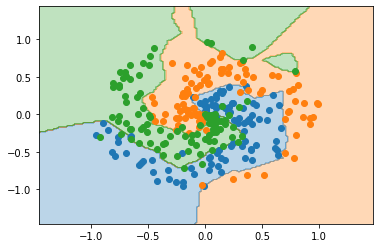

In [62]:
from matplotlib.colors import ListedColormap
# step size
h = 0.02

# mesh grid
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
X_plot = np.c_[xx.ravel(),yy.ravel()]

# forward pass
layer1.forward(X_plot)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

# predictions
y_plot = np.argmax(activation2.output, axis=1)
y_plot = y_plot.reshape(xx.shape)

# classification regions
my_cmap = ListedColormap(['C0','C1','C2'])
plt.contourf(xx, yy, y_plot, cmap=my_cmap, alpha=0.3)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# dataset
for i in range(classes):
    plt.plot(X[y==i,0],X[y==i,1],'o', label='class '+str(i))

## Dropout Layers

In [66]:
# neural network 
layer1 = layer(n_inputs = 2, n_neurons = 100)
activation1 = activation_ReLU()
dropout1 = dropout(.1)
layer2 = layer(n_inputs = 100, n_neurons = 3)
activation2 = activation_softmax()
loss_function = loss_crossentropy()

In [67]:
# optimizer
optimizer = optimizer_Adam(learning_rate = 0.05) 

In [68]:
n_epochs = 2000
loss_adam = np.zeros(n_epochs)
accuracy_adam = np.zeros(n_epochs)
for i in range(n_epochs):
    
    # forward pass
    layer1.forward(X)
    activation1.forward(layer1.output)
    dropout1.forward(activation1.output)
    layer2.forward(dropout1.output)
    activation2.forward(layer2.output)
    
    # loss
    losses = loss_function.forward(activation2.output,y)
    loss_adam[i] = np.mean(losses)
    
    # accuracy
    y_pred = np.argmax(activation2.output,axis=1)
    accuracy_adam[i] = 100*np.sum(y_pred == y)/len(y)
    
    # backward pass
    loss_function.backward(activation2.output,y)
    activation2.backward(loss_function.dinputs)
    layer2.backward(activation2.dinputs)
    dropout1.backward(layer2.dinputs)
    activation1.backward(dropout1.dinputs)
    layer1.backward(activation1.dinputs)
    
    # update weights and biases
    optimizer.pre_update_parameters()
    optimizer.update_parameters(layer1)
    optimizer.update_parameters(layer2)
    optimizer.post_update_parameters()
    
    # print loss and accuracy every 100 epochs
    if i % 100 == 0:
        print('epoch: '+str(i))
        print('loss: '+str(np.round(loss_adam[i],3)))
        print('accuracy: '+str(np.round(accuracy_adam[i],3)))
        print('------------------------')

epoch: 0
loss: 1.099
accuracy: 35.333
------------------------
epoch: 100
loss: 0.58
accuracy: 79.333
------------------------
epoch: 200
loss: 0.506
accuracy: 78.333
------------------------
epoch: 300
loss: 0.514
accuracy: 80.667
------------------------
epoch: 400
loss: 0.47
accuracy: 81.667
------------------------
epoch: 500
loss: 0.547
accuracy: 79.0
------------------------
epoch: 600
loss: 0.449
accuracy: 84.667
------------------------
epoch: 700
loss: 0.462
accuracy: 78.333
------------------------
epoch: 800
loss: 0.458
accuracy: 82.333
------------------------
epoch: 900
loss: 0.503
accuracy: 83.333
------------------------
epoch: 1000
loss: 0.462
accuracy: 81.667
------------------------
epoch: 1100
loss: 0.417
accuracy: 83.667
------------------------
epoch: 1200
loss: 0.449
accuracy: 82.667
------------------------
epoch: 1300
loss: 0.446
accuracy: 78.667
------------------------
epoch: 1400
loss: 0.44
accuracy: 84.333
------------------------
epoch: 1500
loss: 0.438
acc

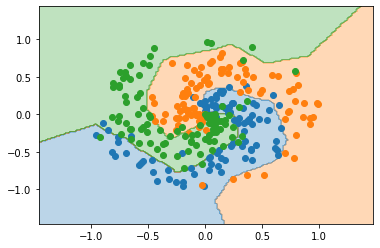

In [69]:
from matplotlib.colors import ListedColormap
# step size
h = 0.02

# mesh grid
x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
X_plot = np.c_[xx.ravel(),yy.ravel()]

# forward pass
layer1.forward(X_plot)
activation1.forward(layer1.output)
layer2.forward(activation1.output)
activation2.forward(layer2.output)

# predictions
y_plot = np.argmax(activation2.output, axis=1)
y_plot = y_plot.reshape(xx.shape)

# classification regions
my_cmap = ListedColormap(['C0','C1','C2'])
plt.contourf(xx, yy, y_plot, cmap=my_cmap, alpha=0.3)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

# dataset
for i in range(classes):
    plt.plot(X[y==i,0],X[y==i,1],'o', label='class '+str(i))